# COMSOL Simulation of the emitting spot size

- Original datafile in: /Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data

- Settings in COMSOL were: -100 kV, 1mA ion beam current

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from scipy.stats import kde
from scipy import optimize

from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

pd.set_option("display.max_columns", 300)


folder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/'

# temporal resolution
outfolder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/temporal_resolution'
files = os.listdir(folder)
files = [f for f in files if "hmesh" not in f]

files = [f for f in files if "particleData" in f]
fignames = files 
files = [f'{folder}/{f}' for f in files if "particleData" in f]


# # number of mesh elements
# outfolder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/temporal_resolution'
# files = os.listdir(folder)
# files = [f for f in files if "hmesh" in f]

# files = [f for f in files if "particleData" in f]
# fignames = files 
# print(fignames)
# files = [f'{folder}/{f}' for f in files if "particleData" in f]




In [ ]:
for fname, figname in zip(files, fignames):
    print(fname, figname)
    data = pd.read_csv(fname, skiprows=7, index_col=0)
    cols = [c for c in data.columns if "2.5E" in c]
    data = data[cols]
    new_cols = []
    for c in cols:
        if 'qx' in c:
            new_cols.append('qx')
        if 'qy' in c:
            new_cols.append('qy')
        if 'qz' in c:
            new_cols.append('qz')
    data.columns = new_cols
    nbins = 200
    lim = 3
#     print(data[pd.isnull(data).any(axis=1)])
    x = data['qy'].values
    y = data['qz'].values
    my_data = np.vstack([x, y])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    # zi = zi/np.max(zi)
    # plot
    fs = 20

    f = plt.figure(1, figsize=(9, 9))

    nullfmt = NullFormatter()         # no labels
    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.12, 0.65
    rect_scatter = [left, bottom, width, height]
    axScatter = plt.axes(rect_scatter)
    p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
    plt.axis('equal')
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
    axScatter.tick_params('x', colors='black', labelsize=fs-2)
    axScatter.tick_params('y', colors='black', labelsize=fs-2)
    plt.yticks(np.arange(-3,4,1))
    plt.xticks(np.arange(-3,4,1))


    left = 0.8
    bottom = 0.12
    width = 0.05
    height = 0.65
    cax = f.add_axes([left, bottom, width, height])
    cbar = f.colorbar(p, cax, ticks=[0,0.05,0.1,0.15])
    print(np.max(zi))
    cbar.ax.tick_params(labelsize=fs-2)
    plt.savefig(f'{outfolder}/{figname}.pdf')

    plt.show()
    
    # query from the estimated pdf
    qry_eval = np.linspace(-lim,lim,100)
    eval_x = [k.evaluate([x,0])[0] for x in qry_eval] # for z = 0 in the upper plot
    eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot

    # fit FWHM
    def gauss(x, a, x0, sigma):
        return a * np.exp(-(x-x0)**2/(2*sigma**2))


    p0 = [1, 1, 1] # Initial guess for the parameters
    # fit for parallel to x axis
    X = qry_eval
    Y = eval_x
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_x, x0_x, sigma_x = popt
    Y_fit_x = gauss(X, *popt)
    FWHM_x = 2 * sigma_x * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in x: {FWHM_x}')

    # fit for parallel to y axis
    X = qry_eval
    Y = eval_y
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_y, x0_y, sigma_y = popt
    FWHM_y = 2 * sigma_y * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in y: {FWHM_y}')
    Y_fit_y = gauss(X, *popt)
    print(gauss(x0_y, *popt), A_y)

    f = plt.figure(1, figsize=(8, 6.4))
    ylims = (-0.01, 0.20)
    # top plot
    plt.subplot(2, 1, 1)
    plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label='z=0')
    plt.plot(qry_eval, Y_fit_x, color='darkred',linewidth=2.0, label='Gaussian fit')
    plt.plot([-FWHM_x/2,FWHM_x/2],[A_x/2,A_x/2], '--', color='black')
    plt.text(-0.5, .12, r'\textbf{FWHM = 2.14 mm}', fontsize=14)
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.3,0.1))
    plt.xticks(np.arange(-3,4,1))
    leg1 = plt.legend(loc="best",  fontsize=12)
    plt.ylim(ylims)
    # bottom plot
    plt.subplot(2, 1, 2)
    plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label='y=0')
    plt.plot(qry_eval, Y_fit_y, color='darkred',linewidth=2.0, label='Gaussian fit')
    plt.plot([-FWHM_y/2+x0_y,FWHM_y/2+x0_y],[gauss(-FWHM_y/2+x0_y,*popt),gauss(FWHM_y/2+x0_y,*popt)], '--', color='black')
    plt.text(-0.5, .12, r'\textbf{FWHM = 2.60 mm}', fontsize=14)
    plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.3,0.1))
    plt.xticks(np.arange(-3,4,1))
    leg1 = plt.legend(loc="best",  fontsize=12)
    # leg1.set_title(r"Experiment number", prop = {'size': 12})
    plt.tight_layout()
    plt.ylim(ylims)
    plt.savefig(f'{outfolder}{figname}_YZ.pdf')
    plt.show()

### Plot for thesis, run 003

In [ ]:
fname = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data//02.MR.102.temporal_refinement.002.particleData.csv'
figname = '02_MR_102_temporal_refinement_002_particleData'
outfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/COMSOL_ion_beam'
data = pd.read_csv(fname, skiprows=7, index_col=0)
cols = [c for c in data.columns if "2.5E" in c]
data = data[cols]
new_cols = []
for c in cols:
    if 'qx' in c:
        new_cols.append('qx')
    if 'qy' in c:
        new_cols.append('qy')
    if 'qz' in c:
        new_cols.append('qz')
data.columns = new_cols
nbins = 200
lim = 3
#     print(data[pd.isnull(data).any(axis=1)])
x = data['qy'].values
y = data['qz'].values
my_data = np.vstack([x, y])
k = kde.gaussian_kde(my_data)

xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# zi = zi/np.max(zi)
# plot
fs = 20

f = plt.figure(1, figsize=(9, 9))

nullfmt = NullFormatter()         # no labels
# definitions for the axes
left, width = 0.12, 0.65
bottom, height = 0.12, 0.65
rect_scatter = [left, bottom, width, height]
axScatter = plt.axes(rect_scatter)
p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
plt.axis('equal')
plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
axScatter.tick_params('x', colors='black', labelsize=fs-2)
axScatter.tick_params('y', colors='black', labelsize=fs-2)
plt.yticks(np.arange(-3,4,1))
plt.xticks(np.arange(-3,4,1))


left = 0.8
bottom = 0.12
width = 0.05
height = 0.65
cax = f.add_axes([left, bottom, width, height])
cbar = f.colorbar(p, cax, ticks=[0,0.05,0.1,0.15])
print(np.max(zi))
cbar.ax.tick_params(labelsize=fs-2)
plt.savefig(f'{outfolder}/{figname}.pdf')

plt.show()

# query from the estimated pdf
qry_eval = np.linspace(-lim,lim,100)
eval_x = [k.evaluate([x,0])[0] for x in qry_eval] # for z = 0 in the upper plot
eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot

# fit FWHM
def gauss(x, a, x0, sigma):
    return a * np.exp(-(x-x0)**2/(2*sigma**2))


p0 = [1, 1, 1] # Initial guess for the parameters
# fit for parallel to x axis
X = qry_eval
Y = eval_x
popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
A_x, x0_x, sigma_x = popt
Y_fit_x = gauss(X, *popt)
FWHM_x = 2 * sigma_x * np.sqrt(2 * np.log(2))  # FWHM
print(f'FWHM in x: {FWHM_x}')

# fit for parallel to y axis
X = qry_eval
Y = eval_y
popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
A_y, x0_y, sigma_y = popt
FWHM_y = 2 * sigma_y * np.sqrt(2 * np.log(2))  # FWHM
print(f'FWHM in y: {FWHM_y}')
Y_fit_y = gauss(X, *popt)
print(gauss(x0_y, *popt), A_y)

f = plt.figure(1, figsize=(8, 6.4))
ylims = (-0.01, 0.20)
# top plot
plt.subplot(2, 1, 1)
plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label='z=0')
plt.plot(qry_eval, Y_fit_x, color='darkred',linewidth=2.0, label='Gaussian fit')
plt.plot([-FWHM_x/2,FWHM_x/2],[A_x/2,A_x/2], '--', color='black')
plt.text(-0.7, .06, r'\textbf{FWHM = 2.22 mm}', fontsize=14)
plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
ax = plt.gca()
ax.tick_params('x', colors='black', labelsize=fs-2)
ax.tick_params('y', colors='black', labelsize=fs-2)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')
plt.yticks(np.arange(0,0.3,0.1))
plt.xticks(np.arange(-3,4,1))
leg1 = plt.legend(loc="best",  fontsize=12)
plt.ylim(ylims)
# bottom plot
plt.subplot(2, 1, 2)
plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label='y=0')
plt.plot(qry_eval, Y_fit_y, color='darkred',linewidth=2.0, label='Gaussian fit')
plt.plot([-FWHM_y/2+x0_y,FWHM_y/2+x0_y],[gauss(-FWHM_y/2+x0_y,*popt),gauss(FWHM_y/2+x0_y,*popt)], '--', color='black')
plt.text(-0.3, .06, r'\textbf{FWHM = 2.65 mm}', fontsize=14)
plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
ax = plt.gca()
ax.tick_params('x', colors='black', labelsize=fs-2)
ax.tick_params('y', colors='black', labelsize=fs-2)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')
plt.yticks(np.arange(0,0.3,0.1))
plt.xticks(np.arange(-3,4,1))
leg1 = plt.legend(loc="best",  fontsize=12)
# leg1.set_title(r"Experiment number", prop = {'size': 12})
plt.tight_layout()
plt.ylim(ylims)
plt.savefig(f'{outfolder}/{figname}_YZ.pdf')
plt.show()

### One file plot

0.22693807929413948


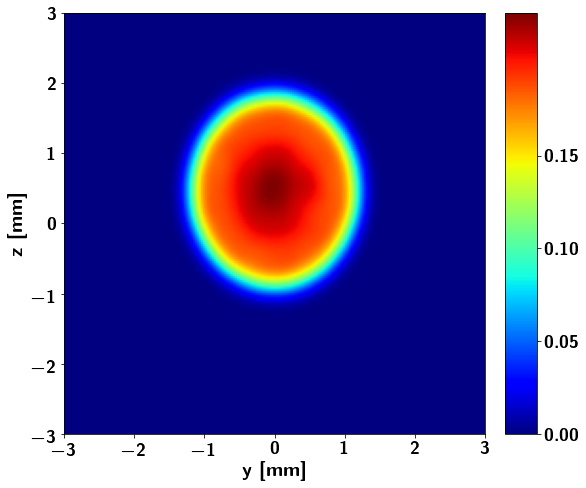

FWHM in x: 1.8156471028719892
FWHM in y: 2.1969756363857784
0.2501486439515794 0.2501486439515794


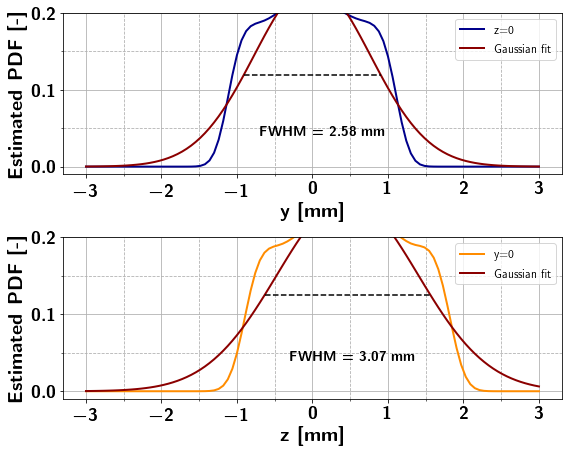

In [8]:
figname = '02.MR.102.temporal_refinement.003_80kV_5k.particleData.csv'
fname = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/02.MR.102.temporal_refinement.003_80kV_5k_13mmEE.particleData.csv'
outfolder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/single_files'

data = pd.read_csv(fname, skiprows=7, index_col=0)
cols = [c for c in data.columns if "2.5E" in c]
data = data[cols]
new_cols = []
for c in cols:
    if 'qx' in c:
        new_cols.append('qx')
    if 'qy' in c:
        new_cols.append('qy')
    if 'qz' in c:
        new_cols.append('qz')
data.columns = new_cols
nbins = 200
lim = 3
#     print(data[pd.isnull(data).any(axis=1)])
x = data['qy'].values
y = data['qz'].values
my_data = np.vstack([x, y])
k = kde.gaussian_kde(my_data)

xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# zi = zi/np.max(zi)
# plot
fs = 20

f = plt.figure(1, figsize=(9, 9))

nullfmt = NullFormatter()         # no labels
# definitions for the axes
left, width = 0.12, 0.65
bottom, height = 0.12, 0.65
rect_scatter = [left, bottom, width, height]
axScatter = plt.axes(rect_scatter)
p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
plt.axis('equal')
plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
axScatter.tick_params('x', colors='black', labelsize=fs-2)
axScatter.tick_params('y', colors='black', labelsize=fs-2)
plt.yticks(np.arange(-3,4,1))
plt.xticks(np.arange(-3,4,1))


left = 0.8
bottom = 0.12
width = 0.05
height = 0.65
cax = f.add_axes([left, bottom, width, height])
cbar = f.colorbar(p, cax, ticks=[0,0.05,0.1,0.15])
print(np.max(zi))
cbar.ax.tick_params(labelsize=fs-2)
plt.savefig(f'{outfolder}/{figname}.pdf')

plt.show()

# query from the estimated pdf
qry_eval = np.linspace(-lim,lim,100)
eval_x = [k.evaluate([x,0])[0] for x in qry_eval] # for z = 0 in the upper plot
eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot

# fit FWHM
def gauss(x, a, x0, sigma):
    return a * np.exp(-(x-x0)**2/(2*sigma**2))


p0 = [1, 1, 1] # Initial guess for the parameters
# fit for parallel to x axis
X = qry_eval
Y = eval_x
popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
A_x, x0_x, sigma_x = popt
Y_fit_x = gauss(X, *popt)
FWHM_x = 2 * sigma_x * np.sqrt(2 * np.log(2))  # FWHM
print(f'FWHM in x: {FWHM_x}')

# fit for parallel to y axis
X = qry_eval
Y = eval_y
popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
A_y, x0_y, sigma_y = popt
FWHM_y = 2 * sigma_y * np.sqrt(2 * np.log(2))  # FWHM
print(f'FWHM in y: {FWHM_y}')
Y_fit_y = gauss(X, *popt)
print(gauss(x0_y, *popt), A_y)

f = plt.figure(1, figsize=(8, 6.4))
ylims = (-0.01, 0.20)
# top plot
plt.subplot(2, 1, 1)
plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label='z=0')
plt.plot(qry_eval, Y_fit_x, color='darkred',linewidth=2.0, label='Gaussian fit')
plt.plot([-FWHM_x/2,FWHM_x/2],[A_x/2,A_x/2], '--', color='black')
plt.text(-0.7, .04, r'\textbf{FWHM = 2.58 mm}', fontsize=14)
plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
ax = plt.gca()
ax.tick_params('x', colors='black', labelsize=fs-2)
ax.tick_params('y', colors='black', labelsize=fs-2)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')
plt.yticks(np.arange(0,0.3,0.1))
plt.xticks(np.arange(-3,4,1))
leg1 = plt.legend(loc="best",  fontsize=12)
plt.ylim(ylims)
# bottom plot
plt.subplot(2, 1, 2)
plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label='y=0')
plt.plot(qry_eval, Y_fit_y, color='darkred',linewidth=2.0, label='Gaussian fit')
plt.plot([-FWHM_y/2+x0_y,FWHM_y/2+x0_y],[gauss(-FWHM_y/2+x0_y,*popt),gauss(FWHM_y/2+x0_y,*popt)], '--', color='black')
plt.text(-0.3, .04, r'\textbf{FWHM = 3.07 mm}', fontsize=14)
plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
ax = plt.gca()
ax.tick_params('x', colors='black', labelsize=fs-2)
ax.tick_params('y', colors='black', labelsize=fs-2)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')
plt.yticks(np.arange(0,0.3,0.1))
plt.xticks(np.arange(-3,4,1))
leg1 = plt.legend(loc="best",  fontsize=12)
# leg1.set_title(r"Experiment number", prop = {'size': 12})
plt.tight_layout()
plt.ylim(ylims)
plt.savefig(f'{outfolder}/{figname}_YZ.pdf')
plt.show()

## Plot along y=0 and y=0

In [ ]:
gauss(FWHM_y/2,A_y, x0_y, sigma_y)

In [ ]:
for COMSOL_data_file in COMSOL_files:

	# import the particle data file
	df_main = pd.read_csv(COMSOL_data_file, skiprows=8, header=None)

	# find column headers
	c = []
	with open(COMSOL_data_file, 'r') as myfile:
		for line in myfile:
			if 'Index' in line:
				l = line.rstrip().split(',')
				c.append(l)

	myfile.close()
	cols = c[0]

	# print(time_cols)
	#set column header of df
	# print(cols)

	cols[0] = 'particleindex'
	df_main.columns = cols

	# get all the sweep values
	s_cols = ','.join(cols)  # join into string
	# sweep_vals = re.findall(sweep_variable + r'=([^,]+),', s_cols)
	# sweep_vals = list(set(sweep_vals))  # get only unique values in the list

	# df_main.to_csv('{}/{}_cleaned.csv'.format(COMSOL_data_file_path,fname))
	# print(cols)
	# print(sweep_vals)
	#
	# sys.exit()

	df_output = pd.DataFrame()  # contains the sweep_variable, FWHM_x, FWHM_y
	runfile = re.findall(r'[^/]+(?=/$|$)', COMSOL_data_file)[0]

	# print(sweep_vals)
	print(f'Doing file {runfile}')


	df = df_main
	df_FWHM = pd.DataFrame()  # this is the output dataframe that contains the FWHM
	cols = df.columns

	# get the time stepping
	# extract t=... from the cols
	my_cols = []
	for ii in range(0,len(cols)):
		col = cols[ii]

		t0 = re.findall(r'(t=.*)', col)
		if len(t0) > 0:
			my_cols.append(t0[0])
		else:
			my_cols.append('noTimestamp')

	# timeStep = my_cols[4]
	time_cols = (pd.Series(item for item in my_cols)).unique()[1:] # drop the timestamp
	# check which particles have arrived at the target
	# get the latest timestamp
	df_last = df.filter(regex=time_cols[-1], axis=1)

	# length: total number of particles
	n_total = len(df_last)

	# only those particles that have made it to the target: 10 mm in +x direction
	# for dist in [1,5,10,80]:
	dist_min = 10
	dist_max = 95
	# print(df_last)
	# print(np.mean(df_last.iloc[:,0]))
	df_arrived = df_last[ (df_last.iloc[:,0] > dist_min) &(df_last.iloc[:,0] < dist_max) ]
	n_arrived = len(df_arrived)
	# print(df_arrived)
	# print(df_last)
	# percent of those that have arrived
	perc_arrived = round((n_arrived/n_total)*100.0,2)

	print('{}% of the initial {} particles have arrived at the target (x > {} mm and x < {} mm).'.format(perc_arrived, n_total, dist_min, dist_max))
	if perc_arrived < 10:
		print('{}% smaller than 10 %, avoid this file).'.format(perc_arrived))
		continue
	# print(df.head())
	# print(sys.exit())
	# index of the particle that have arrived at the target
	idx_arrived = df_arrived.index.tolist()


	# select only the last timestep
	this_df = df.filter(regex=time_cols[-1], axis=1)

	# compute beam radius

	this_df = this_df.iloc[idx_arrived,:]

	qy = this_df.iloc[:,1]
	qz = this_df.iloc[:,2]

	fname = re.findall(r'/([\w.]+).csv',COMSOL_data_file)[0]
	# print(fname)
	# print(COMSOL_data_file)
	directory = '{}/plots/2D_histograms_lastTimestep/IEEE_NSS{}'.format(COMSOL_data_file_path,fname)
	if not os.path.exists(directory):
		os.makedirs(directory)


	mytime = time_cols[-1]
	print('Creating plot for time time {} s'.format(mytime))
	# select only the last timestep
	this_df = df.filter(regex=mytime, axis=1)

	# compute beam radius

	this_df = this_df.iloc[idx_arrived,:]
	qx = this_df.iloc[:,0]
	median_qx = np.median(qx)
	qy = this_df.iloc[:,1]
	qz = this_df.iloc[:,2]
	qr = np.sqrt(qy**2+qz**2)

	nbins = 200
	lim = 2
	x = qy
	y = qz
	data = np.vstack([qy, qz])
	k = kde.gaussian_kde(data)
	# xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
	xi, yi = np.mgrid[-3:3:nbins*1j, -3:3:nbins*1j]
	zi = k(np.vstack([xi.flatten(), yi.flatten()]))
	df_histData = pd.DataFrame()

	df_histData['qx'] = qx
	df_histData['qy'] = qy
	df_histData['qz'] = qz

	# compute FWHM for all points parallel to the x and y axis
	qry_eval = np.linspace(-lim,lim,100)
	eval_x = [k.evaluate([x,0])[0] for x in qry_eval]
	eval_y = [k.evaluate([0,y])[0] for y in qry_eval]

	# print(kint)
	df_res = pd.DataFrame()
	df_res['qry_eval'] = qry_eval
	df_res['eval_x'] = eval_x
	df_res['eval_y'] = eval_y

	# fit FWHM
	# Create a function which returns a Gaussian (normal) distribution.
	def gauss(p, x):
		a, b, c, d = p
		y = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.)) + d
		return y
	def errfunc(p, x, y):
		return gauss(p, x) - y # Distance to the fit function

	p0 = [1, 1, 1, 1] # Initial guess for the parameters


	# fit for parallel to x axis
	X_f = qry_eval
	Y_f = eval_x
	# print(df.norm_cps)
	# print(X_f, Y_f)
	p1, success = optimize.leastsq(errfunc, p0[:], args=(X_f, Y_f), maxfev=100000)
	Y_fit = gauss(p1, X_f)
	# save df to csv
	df_FWHM_x = pd.DataFrame(X_f, columns=['X_fit'])
	df_FWHM_x['Y_fit'] = Y_fit

	df_FWHM_x['sigma'] = p1[2]  # sigma in gaussian
	df_FWHM_x['FWHM'] = 2.08 * p1[2] * np.sqrt(2 * np.log(2))  # FWHM
	# fname = f'{master_folder}/df_FWHM_x.csv'
	# df_FWHM_x.to_csv(fname)
	df_FWHM['FWHM_x'] = df_FWHM_x['FWHM'].unique()

	# fit for parallel to y axis
	X_f = qry_eval
	Y_f = eval_y
	# print(df.norm_cps)
	# print(X_f, Y_f)
	p1, success = optimize.leastsq(errfunc, p0[:], args=(X_f, Y_f))
	Y_fit = gauss(p1, X_f)
	# save df to csv
	df_FWHM_y = pd.DataFrame(X_f, columns=['X_fit'])
	df_FWHM_y['Y_fit'] = Y_fit
	df_FWHM_y['sigma'] = p1[2]  # sigma in gaussian
	df_FWHM_y['FWHM'] = 2.08 * p1[2] * np.sqrt(2 * np.log(2))  # FWHM
	# fname = f'{master_folder}/df_FWHM_y.csv'
	# df_FWHM_y.to_csv(fname)
	df_FWHM['FWHM_y'] = df_FWHM_y['FWHM'].unique()

	df_FWHM['FWHM'] = (np.abs(df_FWHM['FWHM_y']) + np.abs(df_FWHM['FWHM_x']) ) / 2.0

	# tophat
	# plt.plot(X_f, eval_y)
	tophat_params = [ [0, 0, 0, 0], [0, 0, 0, 0] ]  # x, y
	for eval, mode in zip([eval_x, eval_y], ['hat_x_width', 'hat_y_width']):
		guess = [0, 0.3, 0.5, 2.5]
		res = minimize(objective, guess, args=(X_f, eval), method='Nelder-Mead', options={'maxfev': 100000})
		# plt.plot(X_f, tophat(X_f, *(res.x)))
		df_FWHM[mode] = res.x[3]
		if mode == 'hat_x_width':
			tophat_params[0] = res.x
		else:
			tophat_params[1] = res.x

	f = plt.figure(1, figsize=(6, 6))

	# plt.title('KDE Gaussian on target for run \n {}'.format(type_file))
	nullfmt = NullFormatter()         # no labels

	# definitions for the axes
	left, width = 0.12, 0.65
	bottom, height = 0.12, 0.65

	rect_scatter = [left, bottom, width, height]
	axScatter = plt.axes(rect_scatter)

	plt.xlabel('y [mm]', fontsize=16)
	plt.ylabel('z [mm]', fontsize=16)

	p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
	plt.axis('equal')
	# contours = axScatter.contour(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Blues, levels=[my_lvl])
	# plt.clabel(contours, inline=True, fontsize=8)
	axScatter.set_facecolor('#000080ff')
	axScatter.tick_params('x', colors='black', labelsize=14)
	axScatter.tick_params('y', colors='black', labelsize=14)
	axScatter.yaxis.set_ticks([-2, -1, 0, 1, 2])
	axScatter.xaxis.set_ticks([-2, -1, 0, 1, 2])

	left = 0.8
	bottom = 0.12
	width = 0.05
	height = 0.65

	cax = f.add_axes([left, bottom, width, height])
	cbar = f.colorbar(p, cax)

	cbar.ax.tick_params(labelsize=12)

	plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.68,
		wspace=None, hspace=0.2)

	axScatter.set_xlim((-lim, lim))
	axScatter.set_ylim((-lim, lim))

	# compute FWHM for all points parallel to the x and y axis
	qry_eval = np.linspace(-lim, lim, 100)
	eval_x = [k.evaluate([x, 0])[0] for x in qry_eval]
	eval_y = [k.evaluate([0, y])[0] for y in qry_eval]

	# # print(kint)
	# #
	df_res = pd.DataFrame()
	df_res['qry_eval'] = qry_eval
	df_res['eval_x'] = eval_x
	df_res['eval_y'] = eval_y

	filename = '{}/{}'.format(directory, runfile)
	df_histData.to_csv(f'{filename}_df_histData.csv')
	# print(nn)
	# plt.savefig(filename + '.eps', dpi=1200)
	# plt.savefig(filename + '.svg', dpi=1200)
	# plt.tight_layout()
	plt.savefig(filename + '.png', bbox_inches='tight', dpi=600)
	# plt.savefig(filename + '.svg', dpi=600)

	plt.close('all')
	if 'BIDIR' in runfile:
		s_type = 'BIDIR'
	else:
		s_type = 'TD'
	# id = re.findall(r'(\d\d)\.', runfile)[0]
	df_FWHM['id'] = runfile
	df_FWHM['run_type'] = s_type
	df_output = df_output.append(df_FWHM)
	# plt.show()

	fname = f'{directory}/df_FWHMs.csv'
	df_output.to_csv(fname)
